In [1]:
import os
import copy
import easydict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader

from torchmeta.utils.data import BatchMetaDataLoader
from maml.utils import load_dataset, load_model, update_parameters, get_accuracy, get_graph_regularizer

import os
import numpy as np
import pandas as pd

# log graph

In [2]:
def plot_logs(log_type, logs, ax):
    if log_type == 'error':
        train_log = np.array(logs['train_error'])
        valid_log = np.array(logs['valid_error'])
        test_log = np.array(logs['test_error'])
        ymin = 0.0
        ymax = 3.0
        ax.set_title('error graph, test error: {}'.format(round(test_log[-1],4)))
    elif log_type == 'accuracy':
        train_log = np.array(logs['train_accuracy'])
        valid_log = np.array(logs['valid_accuracy'])
        test_log = np.array(logs['test_accuracy'])
        ymin = 0.0
        ymax = 1.0
        ax.set_title('accruacy graph, test accruacy: {}'.format(round(test_log[-1],4)))
    
    ax.plot(train_log.nonzero()[0], train_log[train_log.nonzero()[0]], label='train')
    ax.plot(valid_log.nonzero()[0], valid_log[valid_log.nonzero()[0]], label='valid')
    ax.scatter(test_log.nonzero()[0], test_log[test_log.nonzero()[0]], s=100, color='red', label='test')
    
    ax.set_ylim([ymin, ymax])
    ax.legend()

def plot_diff_logs(filename_list):
    fig, axes = plt.subplots(1, 2, sharey=False, figsize=(16,8))
    
    error_logs_list = []
    accuracy_logs_list = []
    
    for filename in filename_list:
        file_logs = pd.read_csv(filename)
        error_logs_list.append(np.array(file_logs['valid_error']))
        accuracy_logs_list.append(np.array(file_logs['valid_accuracy']))
    
    for filename, error_logs in list(zip(filename_list, error_logs_list)):
        axes[0].plot(error_logs.nonzero()[0], error_logs[error_logs.nonzero()[0]], label="_".join(filename.split("/")[2].split("_")[1:]))
    axes[0].set_ylim([0.0, 3.0])
    axes[0].legend()

    for filename, accuracy_logs in list(zip(filename_list, accuracy_logs_list)):
        axes[1].plot(accuracy_logs.nonzero()[0], accuracy_logs[accuracy_logs.nonzero()[0]], label="_".join(filename.split("/")[2].split("_")[1:]))
    axes[1].set_ylim([0.4, 0.7])
    axes[1].legend()
        
    plt.show()
    plt.close()

In [3]:
path = './output/'
file_list = os.listdir(path)
file_list = sorted([f for f in file_list if 'miniimagenet' in f])
print (file_list)

['miniimagenet_differential_lr', 'miniimagenet_distance_regularizer', 'miniimagenet_distance_regularizer1', 'miniimagenet_distance_regularizer10', 'miniimagenet_distance_regularizer_outer', 'miniimagenet_distance_regularizer_outer10', 'miniimagenet_init_test', 'miniimagenet_json_test', 'miniimagenet_maml', 'miniimagenet_norm_regularizer', 'miniimagenet_only_fc_update_at_inner_update', 'miniimagenet_only_outer', 'miniimagenet_pca_init', 'miniimagenet_pooling_embedding_only_outer', 'miniimagenet_scaling_only_outer', 'miniimagenet_softmax_attention_only_outer', 'miniimagenet_step_size0.01', 'miniimagenet_step_size0.05', 'miniimagenet_step_size0.5', 'miniimagenet_step_size5.0', 'miniimagenet_te_avgpool', 'miniimagenet_te_gcn_manual0.1_l1_concat', 'miniimagenet_te_gcn_manual0.1_l1_concat_fr0.1', 'miniimagenet_te_gcn_manual0.1_l1_concat_gr_b1e-4_g5', 'miniimagenet_te_gcn_maxnorm_l1_concat', 'miniimagenet_te_gcn_maxnorm_l1_output_normalization', 'miniimagenet_te_gcn_maxnorm_l1_output_normaliz

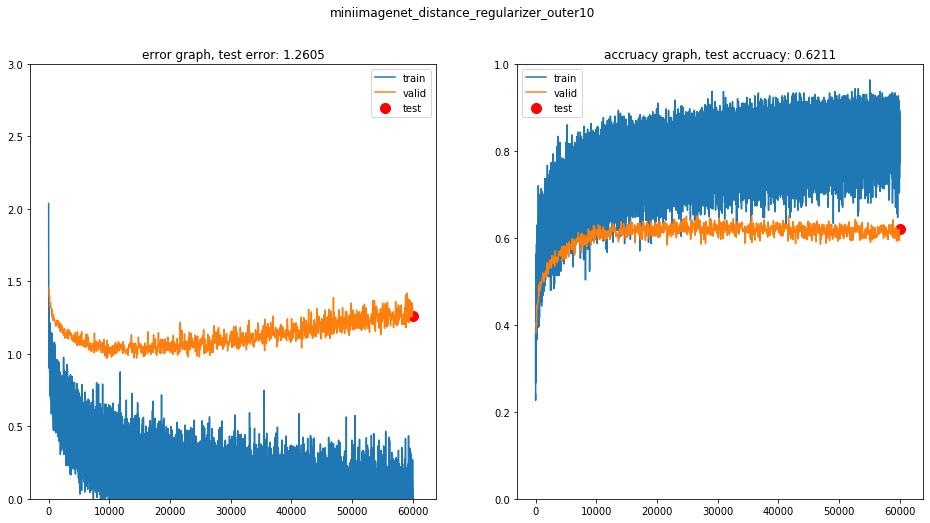

In [7]:
file = [f for f in file_list if 'distance_regularizer_outer' in f]
filename = './output/{}/logs/logs.csv'.format(file[0])
logs = pd.read_csv(filename)

fig, axes = plt.subplots(1, 2, sharey=False, figsize=(16, 8))

plot_logs(log_type='error', logs=logs, ax=axes[0])
plot_logs(log_type='accuracy', logs=logs, ax=axes[1])

plt.suptitle(filename.split("/")[2])
plt.show()
plt.close()

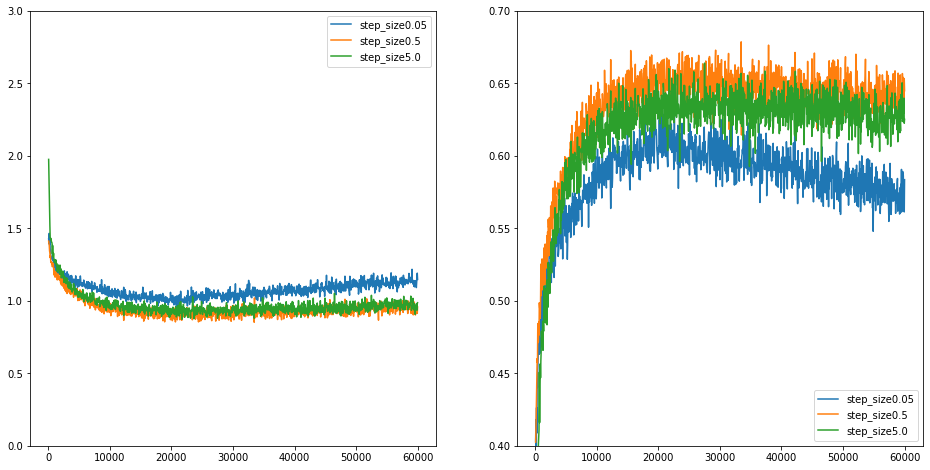

In [5]:
file1 = [f for f in file_list if 'step_size0.05' in f]
file2 = [f for f in file_list if 'step_size0.5' in f]
file3 = [f for f in file_list if 'step_size5.0' in f]

filename1 = './output/{}/logs/logs.csv'.format(file1[0])
filename2 = './output/{}/logs/logs.csv'.format(file2[0])
filename3 = './output/{}/logs/logs.csv'.format(file3[0])

filename_list = [filename1, filename2, filename3]
plot_diff_logs(filename_list)

# Overfitting test
### Overfitting 1: meta train <-> meta test
### Overfitting 2: support <-> query in meta test

In [8]:
args = easydict.EasyDict({'folder': './dataset',
                          'dataset': 'miniimagenet',
                          'device': 'cuda:1',
                          'download': True,
                          'num_shots': 5,
                          'num_ways': 5,
                          'meta_lr': 1e-3,
                          'first_order': False,
                          'step_size': 0.7,
                          'hidden_size': 64,
                          'output_folder': './output/',
                          'save_name': None,
                          'batch_size': 4,
                          'batch_iter': 1200,
                          'train_batches': 50,
                          'valid_batches': 25,
                          'test_batches': 2500,
                          'num_workers': 1,
                          'graph_gamma': 5.0,
                          'graph_beta': 1e-5,
                          'graph_regularizer': False,
                          'fc_regularizer': False,
                          'task_embedding_method': None,
                          'edge_generation_method': None,
                          'best_valid_error_test': False,
                          'best_valid_accuracy_test': False})

In [9]:
def make_sample_task(dataset):
    sample_task = dataset.sample_task()
    for idx, (image, label) in enumerate(sample_task['train']): # support set in meta_test
        if idx == 0:
            s_images = image.unsqueeze(0)
            s_labels = [label]
            s_real_labels = [sample_task['train'].index[label]]
        else:
            s_images = torch.cat([s_images, image.unsqueeze(0)], dim=0)
            s_labels.append(label)
            s_real_labels.append(sample_task['train'].index[label])
    
    for idx, (image, label) in enumerate(sample_task['test']): # query set in meta_test
        if idx == 0:
            q_images = image.unsqueeze(0)
            q_labels = [label]
            q_real_labels = [sample_task['test'].index[label]]
        else:
            q_images = torch.cat([q_images, image.unsqueeze(0)], dim=0)
            q_labels.append(label)
            q_real_labels.append(sample_task['test'].index[label])
    
    s_labels = torch.tensor(s_labels).type(torch.LongTensor)
    s_real_labels = torch.tensor(s_real_labels).type(torch.LongTensor)
    q_labels = torch.tensor(q_labels).type(torch.LongTensor)
    q_real_labels = torch.tensor(q_real_labels).type(torch.LongTensor)
    return [s_images, s_labels, s_real_labels, q_images, q_labels, q_real_labels]

In [10]:
def print_accuracy(args, meta_mode):
    sample_number = 1000
    sample_tasks = [make_sample_task(load_dataset(args, meta_mode)) for _ in tqdm(range(sample_number))]

    before_support_accuracy_list = []
    after_support_accuracy_list = []
    after_query_accuracy_list = []

    for idx in tqdm(range(sample_number)):
        model = load_model(args)
        checkpoint = args.output_folder + '{}_{}/'.format(args.dataset, args.save_name) + 'models/epochs_20000.pt'
        checkpoint = torch.load(checkpoint)
        model.load_state_dict(checkpoint, strict=True)

        model.to(args.device)

        support_input = sample_tasks[idx][0].to(args.device)
        support_target = sample_tasks[idx][1].to(args.device)
        support_real_target = sample_tasks[idx][2]
        query_input = sample_tasks[idx][3].to(args.device)
        query_target = sample_tasks[idx][4].to(args.device)
        query_real_target = sample_tasks[idx][5]

        model.train()
        support_features, support_logit = model(support_input, update_mode='inner')
        _, support_pred_target = torch.max(support_logit, dim=1)
        before_support_accuracy_list.append(sum(support_target==support_pred_target)/float(len(support_target)))

        inner_loss = F.cross_entropy(support_logit, support_target)
        model.zero_grad()
        params = update_parameters(model, inner_loss, step_size=args.step_size, first_order=args.first_order)
        support_features, support_logit = model(support_input, update_mode='inner', params=params) # inner loss를 통해 적어도 1번이라도 업데이트 되었을 때 (params=params 들어갔을 떄), 제대로된 task_embedding이 뽑힘. 근데 뽑는다 한들 어떻게 합치지;;
        _, support_pred_target = torch.max(support_logit, dim=1)
        after_support_accuracy_list.append(sum(support_target==support_pred_target)/float(len(support_target)))

        query_features, query_logit = model(query_input, update_mode='inner', params=params)
        _, query_pred_target = torch.max(query_logit, dim=1)
        after_query_accuracy_list.append(sum(query_target==query_pred_target)/float(len(query_target)))

    before_support_accuracy_list = [v.cpu().item() for v in before_support_accuracy_list]
    after_support_accuracy_list = [v.cpu().item() for v in after_support_accuracy_list]
    after_query_accuracy_list = [v.cpu().item() for v in after_query_accuracy_list]

    print (np.mean(before_support_accuracy_list), np.mean(after_support_accuracy_list), np.mean(after_query_accuracy_list))

In [15]:
# args.step_size = 0.05
# args.save_name = 'step_size{}'.format(str(args.step_size))
args.save_name = 'distance_regularizer10'
print_accuracy(args, meta_mode='meta_train')
print_accuracy(args, meta_mode='meta_test')

  0%|          | 3/1000 [00:00<00:47, 20.93it/s]

0.19599999461323023 0.9621999834179878 0.7979200183749199


100%|██████████| 1000/1000 [00:14<00:00, 66.82it/s]

0.20079999434947968 0.9359999789595604 0.665440014988184
